In [19]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns





In [20]:
data = pd.read_csv(r'C:\Users\caixd\Downloads\ped-fusion-share\df1_v1a_out.csv')
df = data.copy()

#speed lim turned from categorical to numeric var bc too many categories
def avg_speed_range(speed_str):
    speeds = [int(s.replace('mph', '').strip()) for s in speed_str.split('-')]
    return sum(speeds) / len(speeds)
  
df['speed_numeric'] = data['speed_type'].apply(avg_speed_range)

#drop original speed limit var and additional vars not used for prediction
df = df.drop(columns = ['Street Nam', 'site_id','_Date','geometry','speed_type'])

#encode crossing class ordinally
crossing_map = {
    'unmarked': 0,
    'marked': 1,
    'signalized': 2
}
df['crossing_class'] = df['crossing_class'].map(crossing_map)


#encode season with sin cos transformation
season_map = {'winter': 0, 'spring': 1, 'summer': 2, 'fall': 3}
df['season_num'] = df['season'].map(season_map)
df['season_sin'] = np.sin(2 * np.pi * df['season_num'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season_num'] / 4)

#log transform intersec legs
df['Number of'] = np.log(df['Number of'])

df = df.drop(columns = ['season_num','season'])

#separate road df for non catboost models because they don't handle cat vars the same
road_df = df.copy()
road_df[['road_1', 'road_2']] = df['class_type'].str.split('-', n=1, expand=True)
hierarchy = {
    'mot': 5, 
    'tru': 4, 
    'pri': 3,  
    'sec': 2, 
    'ter': 1,  
    'res': 0   
}
road_df['road_1'] = road_df['road_1'].map(hierarchy)
road_df['road_2'] = road_df['road_2'].map(hierarchy)
road_df.drop(columns = ['class_type'], inplace = True)




In [21]:
buffers = set()

#exploration code to look at correlation among the buffers 
for col in df.columns:
    if col.endswith('em'):
        buffers.add(col.replace('_em', ''))

for base_var in sorted(buffers):
    buffer_cols = [col for col in df.columns if col.startswith(base_var)]

    buffer_df = df[buffer_cols]
    print(f"\n----corr matrix for {base_var} buffer----")
    print(buffer_df.corr().to_string(float_format="%.2f"))


----corr matrix for Commercial Area buffer----
                    Commercial Area  Commercial Area_em  Commercial Area_qm  Commercial Area_hm
Commercial Area                1.00                0.58                0.28                0.18
Commercial Area_em             0.58                1.00                0.84                0.67
Commercial Area_qm             0.28                0.84                1.00                0.86
Commercial Area_hm             0.18                0.67                0.86                1.00

----corr matrix for Park Area buffer----
              Park Area  Park Area_em  Park Area_qm  Park Area_hm
Park Area          1.00          0.60          0.52          0.22
Park Area_em       0.60          1.00          0.82          0.23
Park Area_qm       0.52          0.82          1.00          0.49
Park Area_hm       0.22          0.23          0.49          1.00

----corr matrix for Retail Area buffer----
                Retail Area  Retail Area_em  Retail Area

In [22]:

#df = df.drop(columns=[col for col in df.columns if col.endswith('_hm') or col.endswith('em')])
df['class_type'] = df['class_type'].astype('category')



fold 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 129.450000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

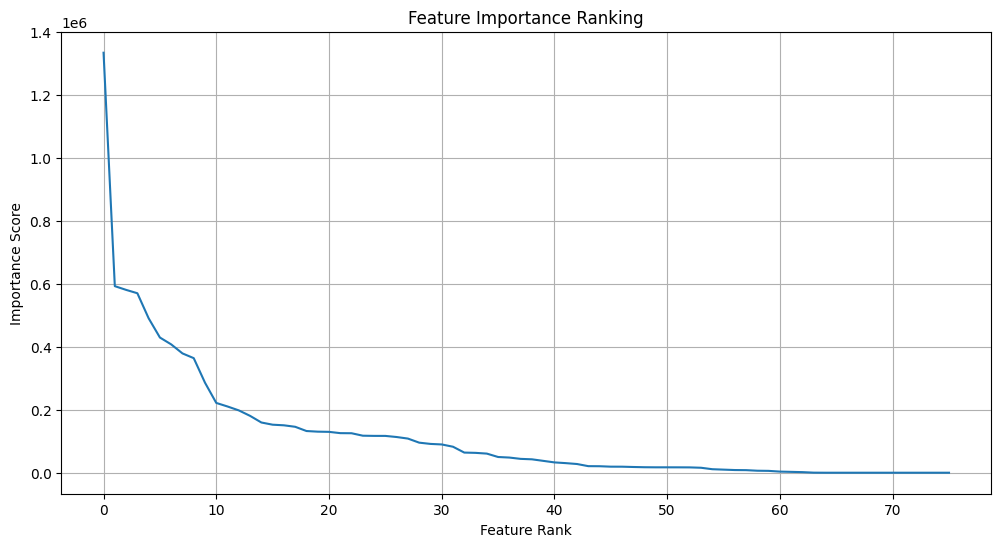

C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\366760472.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


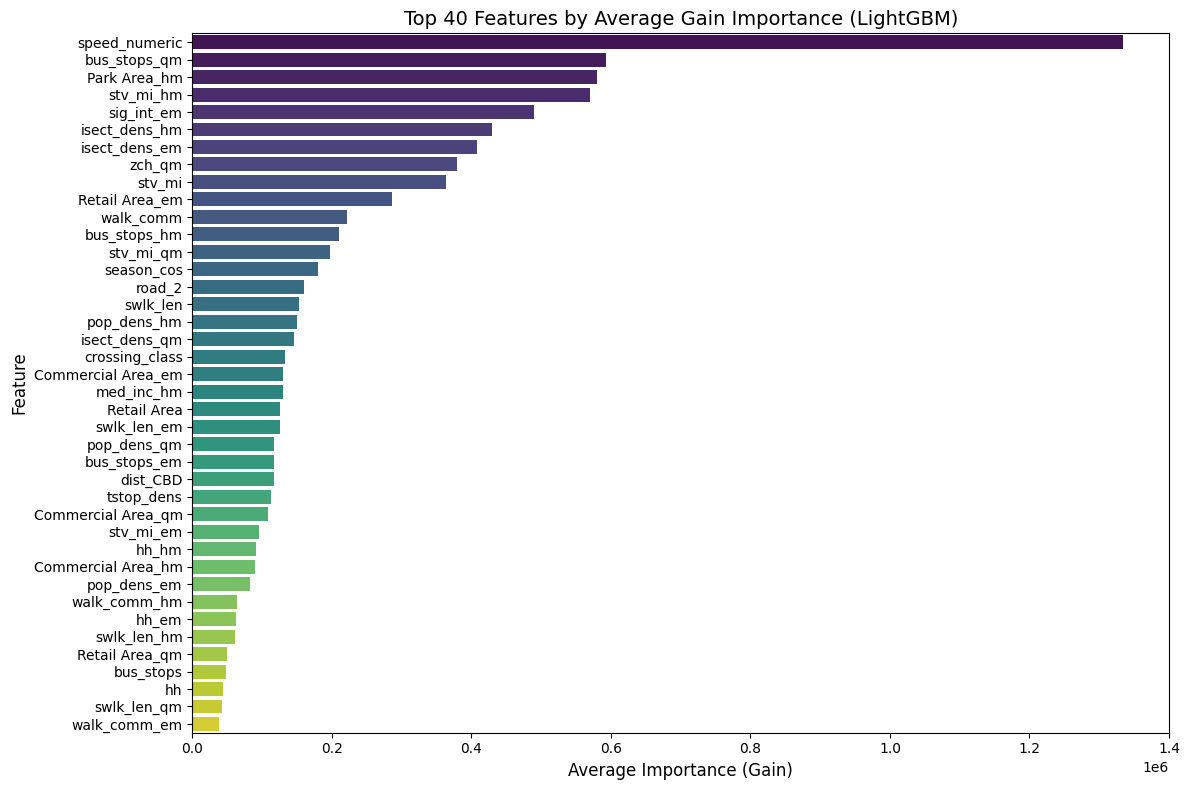

In [23]:
X = road_df.drop(columns=['pm_tot'])  
y = df['pm_tot']  

params = {
    'objective': 'regression',
    'metric': 'rmse',         
    'boosting_type': 'gbdt',
    'seed': 2
}

#running lightgbm across 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#record feature importance for each iteration
feature_importances = pd.DataFrame(index=X.columns)

#iterate through each fold and get feature importances
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\nfold {fold + 1}")
    
    #splits the data into train and test
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
    )
    
    #append to store feature importance based on gain (how much using that feature as a splitting point in the tree improves model performance)
    feature_importances[f'fold_{fold+1}'] = model.feature_importance(importance_type='gain')
    
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f"fold {fold + 1} rmse: {score:.4f}")

#calculating and sorting avg feat importance
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='average', ascending=False)

print("\nfeature importances:")
print(feature_importances['average'].to_string())
top_n = 40
selected_features = feature_importances['average'].sort_values(ascending=False).head(top_n).index.tolist()

print(f"\ntop {top_n} features:")
print(selected_features)


plt.figure(figsize=(12, 6))
plt.plot(range(len(feature_importances)), feature_importances['average'].sort_values(ascending=False))
plt.xlabel('Feature Rank')
plt.ylabel('Importance Score')
plt.title('Feature Importance Ranking')
plt.grid()
plt.show()

#plotting the feature importances as bar chart
top_features = feature_importances.head(top_n).reset_index()
top_features.columns = ['feature', *top_features.columns[1:]]

plt.figure(figsize=(12, 8))
sns.barplot(
    y='feature',
    x='average',
    data=top_features,
    palette='viridis'
)

plt.title(f'Top {top_n} Features by Average Gain Importance (LightGBM)', fontsize=14)
plt.xlabel('Average Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()



fold 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 129.450000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

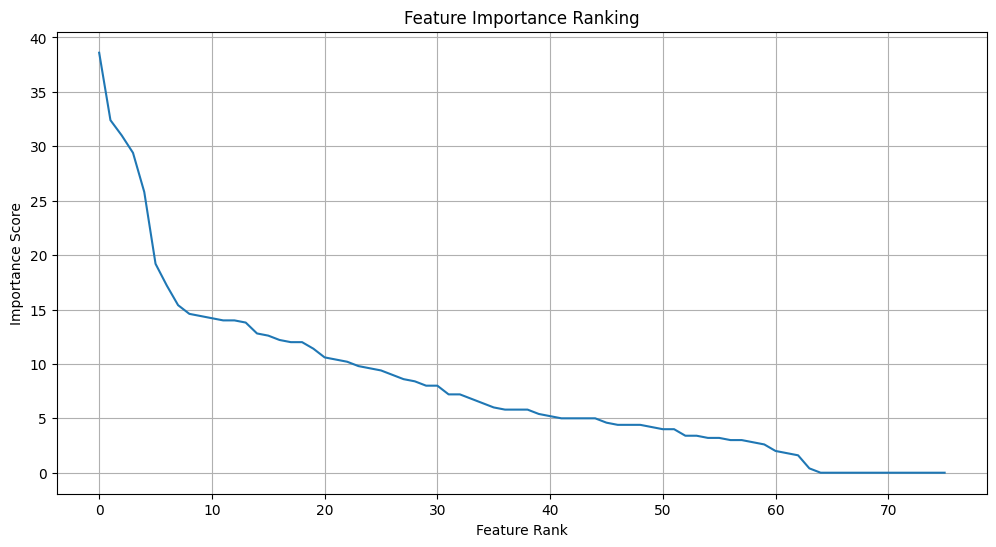

C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\1382975388.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


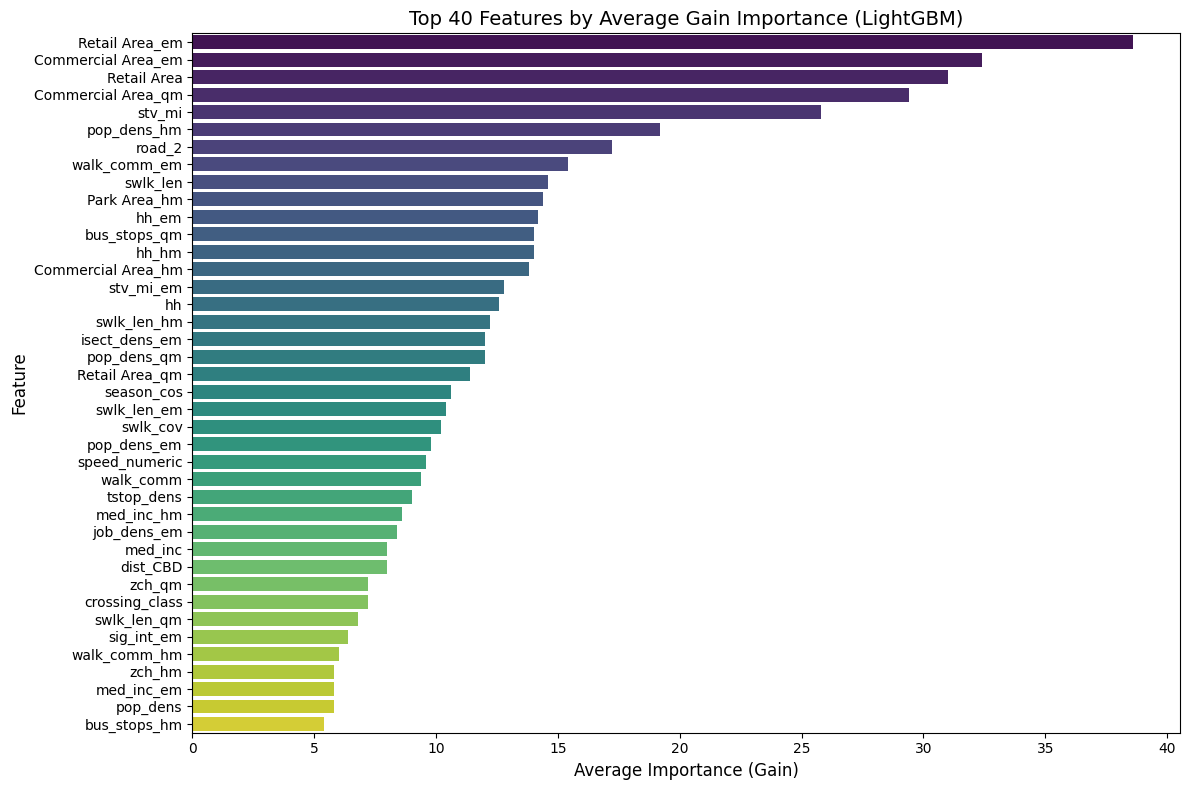

In [24]:
X = road_df.drop(columns=['pm_tot'])  
y = df['pm_tot']  

params = {
    'objective': 'regression',
    'metric': 'rmse',         
    'boosting_type': 'gbdt',
    'seed': 2
}

#running lightgbm across 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#record feature importance for each iteration
feature_importances = pd.DataFrame(index=X.columns)

#iterate through each fold and get feature importances
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\nfold {fold + 1}")
    
    #splits the data into train and test
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[valid_data],
    )
    
    #append to store feature importance based on gain (how much using that feature as a splitting point in the tree improves model performance)
    feature_importances[f'fold_{fold+1}'] = model.feature_importance(importance_type='split')
    
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f"fold {fold + 1} rmse: {score:.4f}")

#calculating and sorting avg feat importance
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='average', ascending=False)

print("\nfeature importances:")
print(feature_importances['average'].to_string())
top_n = 40
selected_features = feature_importances['average'].sort_values(ascending=False).head(top_n).index.tolist()

print(f"\ntop {top_n} features:")
print(selected_features)


plt.figure(figsize=(12, 6))
plt.plot(range(len(feature_importances)), feature_importances['average'].sort_values(ascending=False))
plt.xlabel('Feature Rank')
plt.ylabel('Importance Score')
plt.title('Feature Importance Ranking')
plt.grid()
plt.show()

#plotting the feature importances as bar chart
top_features = feature_importances.head(top_n).reset_index()
top_features.columns = ['feature', *top_features.columns[1:]]

plt.figure(figsize=(12, 8))
sns.barplot(
    y='feature',
    x='average',
    data=top_features,
    palette='viridis'
)

plt.title(f'Top {top_n} Features by Average Gain Importance (LightGBM)', fontsize=14)
plt.xlabel('Average Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+04, tolerance: 1.581e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+04, tolerance: 1.581e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 1:
Best alpha: 2.78256
Best l1_ratio: 1.0
Selected features (27): ['stv_mi', 'stv_ann', 'swlk_cov', 'crossing_island', 'hh', 'zch', 'dist_CBD', 'Commercial Area', 'Retail Area', 'Park Area', 'tstop_dens', 'holdout', 'bus_stops_em', 'pop_dens_em', 'Commercial Area_em', 'stv_mi_qm', 'isect_dens_qm', 'Park Area_qm', 'sig_int_hm', 'sig_dens_hm', 'job_dens_hm', 'Park Area_hm', 'speed_numeric', 'season_sin', 'season_cos', 'road_1', 'road_2']
Test RMSE: 54.6050


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+04, tolerance: 1.626e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+04, tolerance: 1.626e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 2:
Best alpha: 2.78256
Best l1_ratio: 1.0
Selected features (30): ['stv_mi', 'swlk_cov', 'hh', 'dist_CBD', 'Park Area', 'tstop_dens', 'holdout', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'pop_dens_em', 'Commercial Area_em', 'Retail Area_em', 'stv_mi_qm', 'swlk_len_qm', 'bus_stops_qm', 'Commercial Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'job_dens_hm', 'Commercial Area_hm', 'Park Area_hm', 'speed_numeric', 'season_sin', 'road_2']
Test RMSE: 53.0071


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+04, tolerance: 1.479e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+04, tolerance: 1.479e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 3:
Best alpha: 2.78256
Best l1_ratio: 0.9
Selected features (50): ['Number of', 'stv_mi', 'stv_ann', 'swlk_cov', 'bus_stops', 'isect_dens', 'hh', 'zch', 'dist_CBD', 'Retail Area', 'Park Area', 'swlk_len', 'sig_int', 'sig_dens', 'tstop_dens', 'stv_mi_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'hh_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'Park Area_em', 'transit_stops_em', 'swlk_len_qm', 'sig_int_qm', 'sig_dens_qm', 'hh_qm', 'job_dens_qm', 'Commercial Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'hh_hm', 'zch_hm', 'walk_comm_hm', 'job_dens_hm', 'Park Area_hm', 'transit_stops_hm', 'speed_numeric', 'season_sin', 'road_2']
Test RMSE: 62.7122


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+04, tolerance: 1.147e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+04, tolerance: 1.147e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 4:
Best alpha: 2.78256
Best l1_ratio: 0.9
Selected features (45): ['Number of', 'stv_mi', 'stv_ann', 'swlk_cov', 'bus_stops', 'isect_dens', 'hh', 'zch', 'Retail Area', 'swlk_len', 'sig_int', 'sig_dens', 'tstop_dens', 'holdout', 'stv_mi_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'transit_stops_em', 'sig_int_qm', 'sig_dens_qm', 'pop_dens_qm', 'walk_comm_qm', 'job_dens_qm', 'stv_mi_hm', 'swlk_len_hm', 'sig_int_hm', 'sig_dens_hm', 'hh_hm', 'zch_hm', 'pop_dens_hm', 'walk_comm_hm', 'job_dens_hm', 'Commercial Area_hm', 'Retail Area_hm', 'Park Area_hm', 'speed_numeric', 'season_sin', 'road_1', 'road_2']
Test RMSE: 142.3029


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.012e+03, tolerance: 1.435e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.474e+03, tolerance: 1.435e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 5:
Best alpha: 0.05995
Best l1_ratio: 0.5
Selected features (73): ['Number of', 'stv_mi', 'stv_ann', 'swlk_cov', 'crossing_class', 'crossing_island', 'bus_stops', 'isect_dens', 'hh', 'zch', 'pop_dens', 'med_inc', 'job_dens', 'dist_CBD', 'Commercial Area', 'Retail Area', 'Park Area', 'swlk_len', 'sig_int', 'sig_dens', 'tstop_dens', 'walk_comm', 'holdout', 'stv_mi_em', 'swlk_len_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'zch_em', 'med_inc_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'Park Area_em', 'transit_stops_em', 'stv_mi_qm', 'swlk_len_qm', 'bus_stops_qm', 'sig_int_qm', 'sig_dens_qm', 'isect_dens_qm', 'hh_qm', 'zch_qm', 'med_inc_qm', 'pop_dens_qm', 'job_dens_qm', 'Commercial Area_qm', 'Retail Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'hh_hm', 'zch_hm', 'med_inc_hm', 'pop_dens_hm', 'walk_comm_hm', 'job_dens_hm', 'Commercial Area_hm'

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+04, tolerance: 1.744e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e+04, tolerance: 1.744e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 6:
Best alpha: 10.00000
Best l1_ratio: 0.1
Selected features (73): ['Number of', 'stv_mi', 'stv_ann', 'crossing_class', 'crossing_island', 'bus_stops', 'isect_dens', 'hh', 'zch', 'pop_dens', 'med_inc', 'job_dens', 'dist_CBD', 'Commercial Area', 'Retail Area', 'Park Area', 'swlk_len', 'sig_int', 'sig_dens', 'walk_comm', 'holdout', 'stv_mi_em', 'swlk_len_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'hh_em', 'zch_em', 'med_inc_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'Park Area_em', 'transit_stops_em', 'stv_mi_qm', 'swlk_len_qm', 'bus_stops_qm', 'sig_int_qm', 'sig_dens_qm', 'isect_dens_qm', 'zch_qm', 'med_inc_qm', 'pop_dens_qm', 'walk_comm_qm', 'job_dens_qm', 'Commercial Area_qm', 'Retail Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'isect_dens_hm', 'hh_hm', 'zch_hm', 'med_inc_hm', 'pop_dens_hm', 'walk_comm_hm', 'job_dens_hm', 'Commercial 

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+04, tolerance: 1.196e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+04, tolerance: 1.196e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 7:
Best alpha: 0.77426
Best l1_ratio: 0.7
Selected features (65): ['Number of', 'stv_mi', 'stv_ann', 'swlk_cov', 'crossing_class', 'crossing_island', 'isect_dens', 'hh', 'pop_dens', 'med_inc', 'job_dens', 'dist_CBD', 'Commercial Area', 'Retail Area', 'Park Area', 'swlk_len', 'sig_int', 'sig_dens', 'tstop_dens', 'walk_comm', 'holdout', 'stv_mi_em', 'swlk_len_em', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'hh_em', 'zch_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'Park Area_em', 'transit_stops_em', 'stv_mi_qm', 'swlk_len_qm', 'bus_stops_qm', 'sig_int_qm', 'sig_dens_qm', 'hh_qm', 'pop_dens_qm', 'walk_comm_qm', 'job_dens_qm', 'Commercial Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'isect_dens_hm', 'zch_hm', 'pop_dens_hm', 'walk_comm_hm', 'job_dens_hm', 'Commercial Area_hm', 'Retail Area_hm', 'Park Area_hm', 'transit_stops_hm', 'speed_numeric', 'season_sin', 'se

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.900e+03, tolerance: 1.748e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+04, tolerance: 1.748e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 8:
Best alpha: 10.00000
Best l1_ratio: 1.0
Selected features (17): ['stv_mi', 'stv_ann', 'Retail Area', 'Park Area', 'sig_int', 'sig_dens', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'Commercial Area_em', 'sig_int_hm', 'sig_dens_hm', 'job_dens_hm', 'Park Area_hm', 'speed_numeric', 'season_cos', 'road_2']
Test RMSE: 59.3192


c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+04, tolerance: 1.554e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+04, tolerance: 1.554e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 9:
Best alpha: 2.78256
Best l1_ratio: 0.5
Selected features (64): ['Number of', 'stv_mi', 'stv_ann', 'swlk_cov', 'crossing_class', 'crossing_island', 'bus_stops', 'isect_dens', 'hh', 'med_inc', 'job_dens', 'dist_CBD', 'Commercial Area', 'Retail Area', 'Park Area', 'swlk_len', 'sig_int', 'sig_dens', 'tstop_dens', 'walk_comm', 'holdout', 'stv_mi_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'zch_em', 'med_inc_em', 'pop_dens_em', 'walk_comm_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'Park Area_em', 'transit_stops_em', 'stv_mi_qm', 'bus_stops_qm', 'sig_int_qm', 'sig_dens_qm', 'isect_dens_qm', 'hh_qm', 'med_inc_qm', 'pop_dens_qm', 'job_dens_qm', 'Commercial Area_qm', 'Park Area_qm', 'transit_stops_qm', 'stv_mi_hm', 'swlk_len_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'isect_dens_hm', 'zch_hm', 'pop_dens_hm', 'walk_comm_hm', 'job_dens_hm', 'Commercial Area_hm', 'Park Area_hm', 'transit_stops_hm', 'speed_numeric', 'season_sin', 'season_cos', 'road_1', 'road_2

c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e+03, tolerance: 1.263e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e+03, tolerance: 1.263e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 


Fold 10:
Best alpha: 10.00000
Best l1_ratio: 0.9
Selected features (43): ['Number of', 'stv_mi', 'stv_ann', 'crossing_class', 'pop_dens', 'med_inc', 'job_dens', 'dist_CBD', 'Commercial Area', 'swlk_len', 'sig_int', 'sig_dens', 'stv_mi_em', 'swlk_len_em', 'bus_stops_em', 'sig_int_em', 'sig_dens_em', 'isect_dens_em', 'med_inc_em', 'job_dens_em', 'Commercial Area_em', 'Retail Area_em', 'transit_stops_em', 'bus_stops_qm', 'sig_int_qm', 'sig_dens_qm', 'isect_dens_qm', 'med_inc_qm', 'pop_dens_qm', 'job_dens_qm', 'transit_stops_qm', 'stv_mi_hm', 'bus_stops_hm', 'sig_int_hm', 'sig_dens_hm', 'zch_hm', 'job_dens_hm', 'Retail Area_hm', 'Park Area_hm', 'transit_stops_hm', 'speed_numeric', 'road_1', 'road_2']
Test RMSE: 90.9817
Mean RMSE: 86.9193 (±34.0380)
Mean MAE: 62.2129 (±21.1657)
Mean R²: 0.3375 (±0.5413)

Feature selection frequency across folds:
           feature  selected_in_folds  selection_ratio
            stv_mi                 10              1.0
     speed_numeric                 1

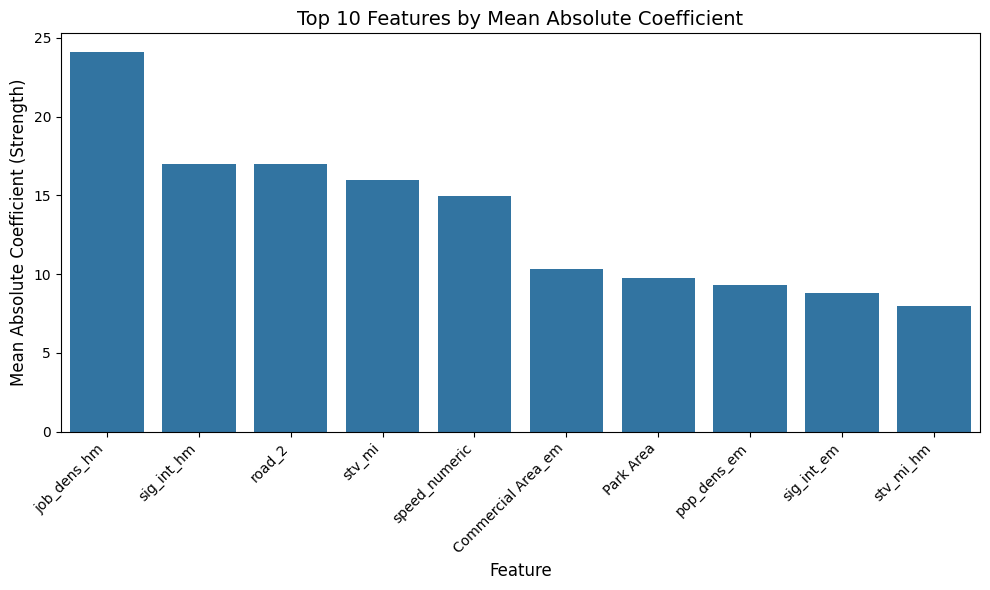

In [73]:

#this cell is for elastic net feature selection

#using the differently encoded road var here
X = road_df.drop(columns='pm_tot')
y = df['pm_tot']


outer_cv = KFold(n_splits=10, shuffle=True, random_state=2)
rmse_scores = []
mae_scores = []
r2_scores = []

feature_names = X.columns
feature_selection_counts = np.zeros(len(feature_names))

#storing coefs per fold
coef_matrix = pd.DataFrame(index=range(outer_cv.get_n_splits()), columns=feature_names)

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=1
    )

    best_score = float('inf')
    best_model = None

    #tune hyperparameters
    for alpha in np.logspace(-4, 1, 10):
        for l1_ratio in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
            model = ElasticNet(
                alpha=alpha,
                l1_ratio=l1_ratio,
                max_iter=5000,
                random_state=2
            )
            model.fit(X_train_sub, y_train_sub)
            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred)

            if score < best_score:
                best_score = score
                best_model = model

    #track which features are used in the folds
    coef_series = pd.Series(best_model.coef_, index=feature_names)
    coef_matrix.loc[fold - 1] = coef_series
    feature_selection_counts += (coef_series != 0).astype(int)

    #eval
    y_pred = best_model.predict(X_test_scaled)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

    selected_feats = coef_series[coef_series != 0].index
    print(f"\nFold {fold}:")
    print(f"Best alpha: {best_model.alpha:.5f}")
    print(f"Best l1_ratio: {best_model.l1_ratio}")
    print(f"Selected features ({len(selected_feats)}): {selected_feats.to_list()}")
    print(f"Test RMSE: {rmse_scores[-1]:.4f}")

print(f"Mean RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"Mean MAE: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")
print(f"Mean R²: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")

#shows how often features were selected
selection_df = pd.DataFrame({
    'feature': feature_names,
    'selected_in_folds': feature_selection_counts.astype(int),
    'selection_ratio': feature_selection_counts / outer_cv.get_n_splits()
}).sort_values(by='selection_ratio', ascending=False)

print("\nFeature selection frequency across folds:")
print(selection_df.to_string(index=False))

#get statistics for feature coefficients
coef_stats = pd.DataFrame({
    'mean_coef': coef_matrix.astype(float).mean(),
    'std_coef': coef_matrix.astype(float).std(),
    'abs_mean_coef': coef_matrix.astype(float).abs().mean(),
    'selection_count': feature_selection_counts.astype(int),
}).sort_values(by='abs_mean_coef', ascending=False)

#10 highest coefficients
top_strong = coef_stats.head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='abs_mean_coef', data=top_strong, color="#1f77b4")
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Features by Mean Absolute Coefficient', fontsize=14)
plt.ylabel('Mean Absolute Coefficient (Strength)', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()




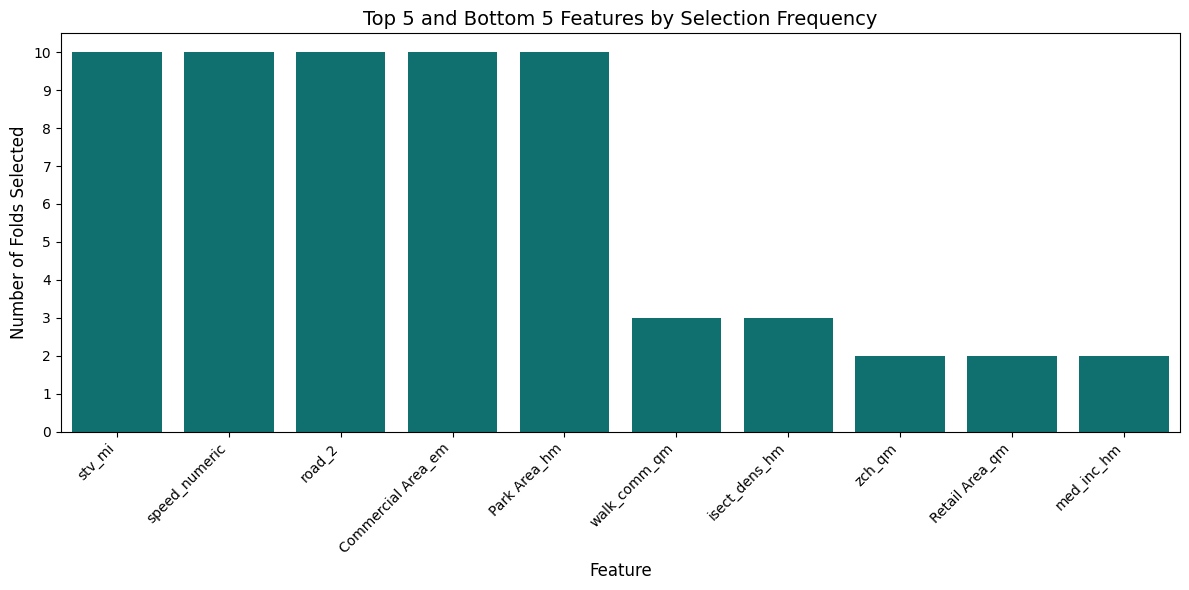

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#sort features by selection frequency
selection_df_sorted = selection_df.sort_values(by='selected_in_folds', ascending=False)

#get top 5 and bottom 5 most selected features
top_5 = selection_df_sorted.head(5)
bottom_5 = selection_df_sorted.tail(5)
top_bottom_df = pd.concat([top_5, bottom_5])


# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='feature',
    y='selected_in_folds',
    data=top_bottom_df,
    color='teal'
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 and Bottom 5 Features by Selection Frequency', fontsize=14)
plt.ylabel('Number of Folds Selected', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.ylim(0, 10.5)
plt.yticks(range(0, 11))
plt.tight_layout()
plt.show()


In [26]:
#dropping the cols that were at bottom of importance for elasticnet and lightgbm
#lightgbm importances take priority since it is tree based
#some were not dropped based on theoretical importance, e.g. the strava_ann was very low in lightgbm but high in elasticnet, and 
#theoretically it should be a decent proxy for ped count




final = df.drop(columns=[
    'crossing_island',
    'isect_dens',
    'Park Area',
    'sig_dens',
    'sig_int',
    'sig_dens_em',
    'sig_dens_hm',
    'sig_dens_qm',
    'transit_stops_hm',
    'med_inc_hm',
    'Retail Area_qm',
    'zch_qm',
    'Number of'
]) 


finalroad = road_df.drop(columns=[
    'crossing_island',
    'isect_dens',
    'Park Area',
    'sig_dens',
    'sig_int',
    'sig_dens_em',
    'sig_dens_hm',
    'transit_stops_hm',
    'med_inc_hm',
    'Retail Area_qm',
    'zch_qm',
    'Number of'
]) 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.079788
0:	learn: 145.5713398	test: 135.3255716	best: 135.3255716 (0)	total: 33ms	remaining: 8.21s
1:	learn: 140.7835343	test: 130.4577502	best: 130.4577502 (1)	total: 65.5ms	remaining: 8.12s
2:	learn: 136.9101976	test: 126.8842100	best: 126.8842100 (2)	total: 94.5ms	remaining: 7.78s
3:	learn: 132.3101615	test: 123.5422392	best: 123.5422392 (3)	total: 134ms	remaining: 8.23s
4:	learn: 127.0837179	test: 119.3210070	best: 119.3210070 (4)	total: 173ms	remaining: 8.5s
5:	learn: 122.5339675	test: 115.6250230	best: 115.6250230 (5)	total: 207ms	remaining: 8.41s
6:	learn: 118.8857691	test: 111.2045411	best: 111.2045411 (6)	total: 243ms	remaining: 8.43s
7:	learn: 114.3724395	test: 107.1105930	best: 107.1105930 (7)	total: 276ms	remaining: 8.36s
8:	learn: 111.2109210	test: 105.0787844	best: 105.0787844 (8)	total: 311ms	remaining: 8.32s
9:	learn: 107.8958790	test: 102.2084949	best: 102.2084949 (9)	total: 345ms	remaining: 8.27s
10:	learn: 105.0411160	test: 99.4921666	best: 99.4

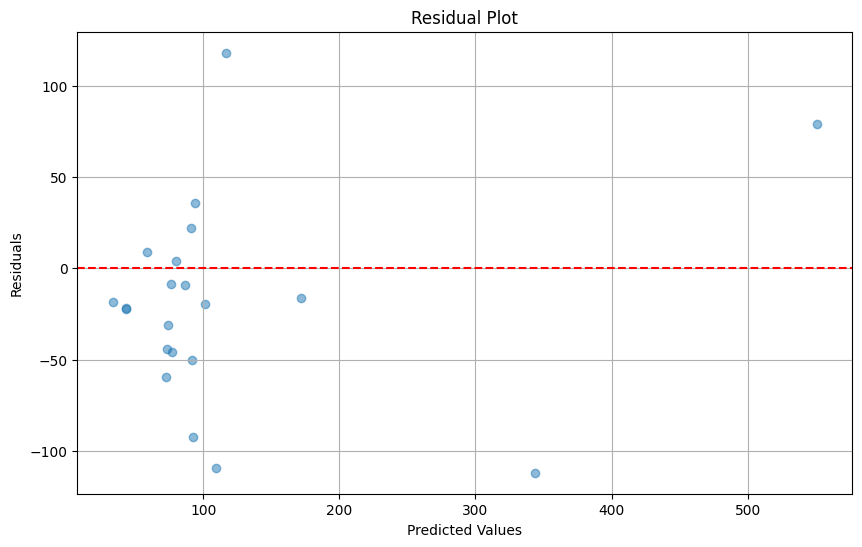

In [27]:
#test catboost method, using one train test split, swapping random state changes performance significantly

X = final.drop(columns = ['pm_tot'])
y = df['pm_tot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

model = CatBoostRegressor(
    cat_features=cat_features,
    iterations=250,
    eval_metric='RMSE',
    random_seed=2
)


model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True,
)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance.to_string(index=False))

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Evaluation Metrics:
RMSE: 102.3935
R²: 0.6565

Feature Importances:
           Feature  Importance
        sig_int_em   10.127458
         stv_mi_hm    5.937446
       job_dens_em    5.507898
      bus_stops_hm    5.067630
    Retail Area_em    5.038462
Commercial Area_em    4.677588
     speed_numeric    4.248801
        sig_int_hm    3.944493
       job_dens_qm    3.770569
    crossing_class    3.653785
            zch_hm    2.770725
        sig_int_qm    2.679696
       job_dens_hm    2.570516
       Retail Area    2.555489
          dist_CBD    2.336834
     isect_dens_hm    2.104677
        season_cos    2.053154
     isect_dens_em    1.752990
           stv_ann    1.621336
Commercial Area_qm    1.605513
      walk_comm_qm    1.468832
             hh_em    1.327893
      bus_stops_em    1.221762
            stv_mi    1.207703
      bus_stops_qm    1.116626
            zch_em    1.036630
             hh_hm    0.922005
    Retail Area_hm    0.870917
  transit_stops_qm    0.862574
 

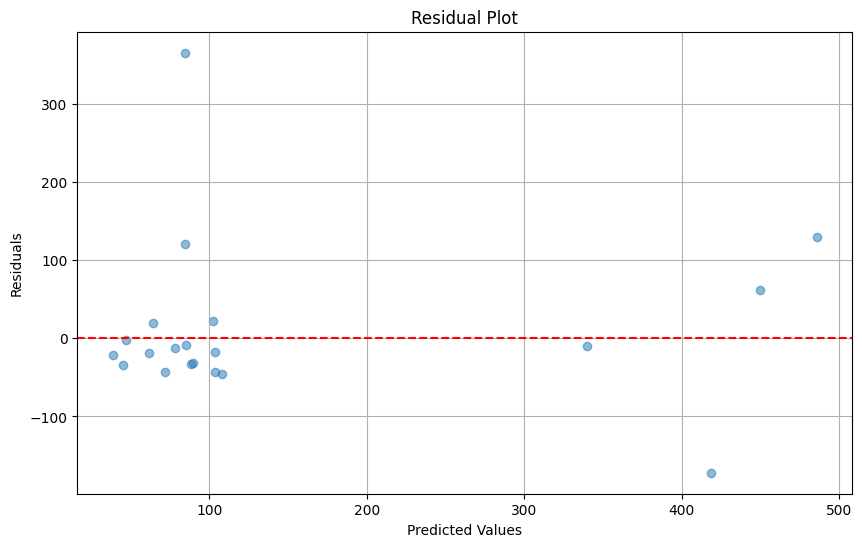

In [30]:
#using same holdout for test as the neg binom

X = final.drop(columns=['pm_tot'])
y = df['pm_tot']

train_mask = df['holdout'] == 0
test_mask = df['holdout'] == 1

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

model = CatBoostRegressor(
    cat_features=cat_features,
    iterations=250,
    eval_metric='RMSE',
    random_seed=2,
    verbose=0,
    #boosting_type = 'Ordered'
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True,
)

#evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance.to_string(index=False))

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


In [35]:
#test catboost using leave one out cross val for more stable measure
X = final.drop(columns=['pm_tot'])
y = df['pm_tot']

#separating categorical features
cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

loo = LeaveOneOut()

#setting up stores of performance and across bins
rmse_scores = []
rmse_bins = []
all_actuals = []
all_preds = []
all_residuals = []

bins = list(range(0, 701, 100))
bin_labels = [f"{i+1}-{i+100}" if i != 0 else "0-100" for i in bins[:-1]]

#loocv
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = CatBoostRegressor(
        cat_features=cat_features,
        iterations=300,
        eval_metric='RMSE',
        random_seed=2,
        verbose=0,
    )
    
    #evaluate model and store performance
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    actual_val = y_test.values[0]
    pred_val = y_pred[0]
    residual = actual_val - pred_val

    all_actuals.append(actual_val)
    all_preds.append(pred_val)
    all_residuals.append(residual)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    bin_index = pd.cut([actual_val], bins=bins, labels=bin_labels, right=True)[0]
    rmse_bins.append(bin_index)

#evaluate models 
overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
mae = mean_absolute_error(all_actuals, all_preds)

#store the measures later for plotting
results_df_cb = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Residual': all_residuals,
    'RMSE': rmse_scores,
    'Bin': rmse_bins
})

print(f"overall rmse: {overall_rmse:.4f}")
print(f"mae: {mae:.4f}")



overall rmse: 85.0473
mae: 53.8117


In [40]:
#neg binom to plot later, significant part of this is generated with deepseek
import statsmodels.formula.api as smf
import statsmodels.api as sm
dfnb = pd.read_csv(r'C:\Users\caixd\Downloads\ped-fusion-share\df1_v1a_out.csv')
dfnb.rename(columns={
    'Number of': 'number_of',
    'Retail Area_qm': 'retail_area_qm',
    'Commercial Area': 'commercial_area',
    'Retail Area': 'retail_area'
}, inplace=True)

dfnb['crossing_class'] = pd.Categorical(dfnb['crossing_class'], categories=['unmarked', 'marked', 'signalized'], ordered=True)
dfnb['speed_type'] = dfnb['speed_type'].astype('category')
dfnb['has_commercial_or_retail'] = ((dfnb['commercial_area'] + dfnb['retail_area']) > 0).astype(int)

# Model formula
formula = """pm_tot ~ np.log(number_of) + dist_CBD + 
has_commercial_or_retail +
C(crossing_class) + C(speed_type) +
retail_area_qm + transit_stops_qm"""

# Estimate alpha for negative binomial
initial_model = smf.glm(formula=formula, data=dfnb, family=sm.families.NegativeBinomial()).fit()
alpha = 1 / initial_model.scale

# LOOCV setup
loo = LeaveOneOut()
actuals = []
predictions = []
residuals = []

print("LOOCV Results:")
print("-------------")
print("Fold\tSite ID\tActual\tPredicted\tResidual")

for fold_idx, (train_idx, test_idx) in enumerate(loo.split(dfnb)):
    X_train, X_test = dfnb.iloc[train_idx], dfnb.iloc[test_idx]
    
    model = smf.glm(formula=formula,
                    data=X_train,
                    family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    pred = model.predict(X_test).values[0]
    actual = X_test['pm_tot'].values[0]
    residual = actual - pred
    
    predictions.append(pred)
    actuals.append(actual)
    residuals.append(residual)

    print(f"{fold_idx}\t{X_test['site_id'].values[0]}\t{actual:.1f}\t{pred:.1f}\t{residual:.2f}")

# Final dataframe for evaluation
results_df_nb = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions,
    'Residual': residuals,
})
results_df_nb['Absolute Error'] = np.abs(results_df_nb['Residual'])
results_df_nb['Squared Error'] = results_df_nb['Residual'] ** 2

# Bin setup
bins = list(range(0, 701, 100))
bin_labels = [f"{i+1}-{i+100}" if i != 0 else "0-100" for i in bins[:-1]]
results_df_nb['Bin'] = pd.cut(results_df_nb['Actual'], bins=bins, labels=bin_labels, right=True)

# Overall metrics
overall_rmse = np.sqrt(mean_squared_error(results_df_nb['Actual'], results_df_nb['Predicted']))
mae = mean_absolute_error(results_df_nb['Actual'], results_df_nb['Predicted'])

print("\nModel Performance:")
print("------------------")
print(f"Overall RMSE: {overall_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

bin_mae = results_df_nb.groupby('Bin')['Absolute Error'].mean()
bin_rmse = results_df_nb.groupby('Bin')['Squared Error'].mean().apply(np.sqrt)
bin_counts = results_df_nb['Bin'].value_counts().reindex(bin_labels)

bin_stats_nb = pd.DataFrame({
    'MAE': bin_mae,
    'RMSE': bin_rmse,
    'Count': bin_counts
})



c:\Users\caixd\Documents\PSU reu\venv312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


LOOCV Results:
-------------
Fold	Site ID	Actual	Predicted	Residual
0	1	115.0	128.0	-13.02
1	2	114.0	107.2	6.80
2	3	21.0	65.2	-44.21
3	4	40.0	73.0	-32.95
4	5	41.0	47.5	-6.51
5	6	38.0	49.7	-11.67
6	7	116.0	159.1	-43.06
7	8	68.0	149.9	-81.88
8	9	42.0	74.6	-32.61
9	10	62.0	89.5	-27.52
10	11	80.0	158.1	-78.09
11	12	144.0	138.7	5.28
12	13	279.0	108.1	170.88
13	14	13.0	38.5	-25.45
14	15	46.0	38.1	7.85
15	16	22.0	58.8	-36.82
16	17	31.0	52.1	-21.06
17	18	27.0	70.3	-43.25
18	19	75.0	98.6	-23.65
19	20	83.0	34.9	48.06
20	21	26.0	36.8	-10.75
21	22	112.0	71.6	40.36
22	23	43.0	61.1	-18.14
23	24	30.0	23.4	6.60
24	25	21.0	56.3	-35.30
25	26	51.0	36.6	14.38
26	27	15.0	39.1	-24.05
27	28	55.0	71.4	-16.37
28	29	148.0	107.4	40.64
29	30	86.0	70.5	15.55
30	31	68.0	45.2	22.75
31	32	58.0	128.5	-70.52
32	33	24.0	27.3	-3.32
33	34	77.0	61.2	15.79
34	35	58.0	71.2	-13.20
35	36	205.0	164.9	40.11
36	37	215.0	185.2	29.80
37	38	60.0	150.8	-90.80
38	39	11.0	26.7	-15.66
39	40	329.0	128.4	200.64
40	41	9.0	118.9	-109.92
41	

C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\2198289190.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mae = results_df_nb.groupby('Bin')['Absolute Error'].mean()
C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\2198289190.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rmse = results_df_nb.groupby('Bin')['Squared Error'].mean().apply(np.sqrt)


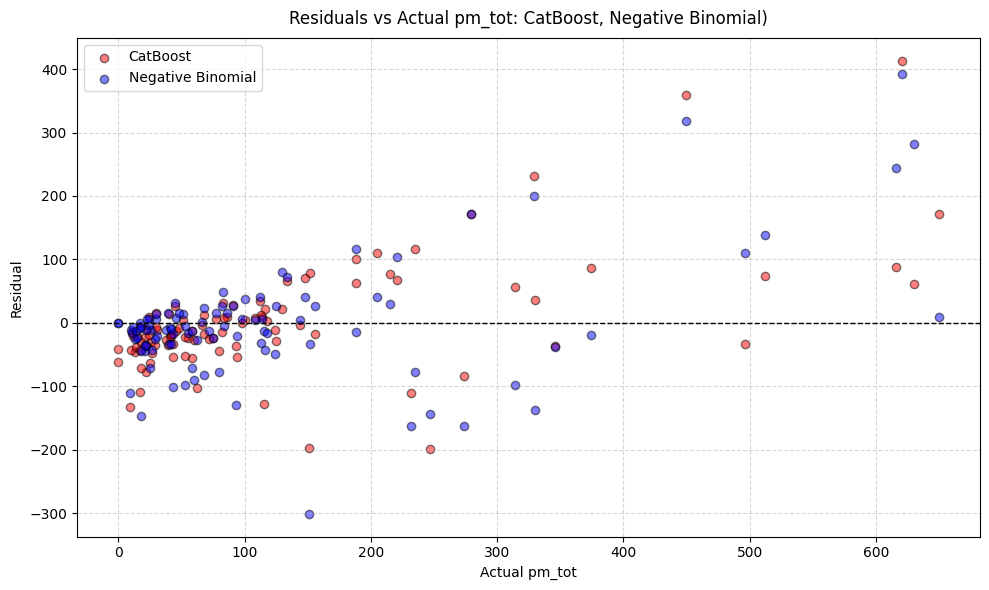

C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\479890951.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f'{model_name}_MAPE': grouped.apply(lambda g:
C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\479890951.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Bin')
C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\479890951.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping col

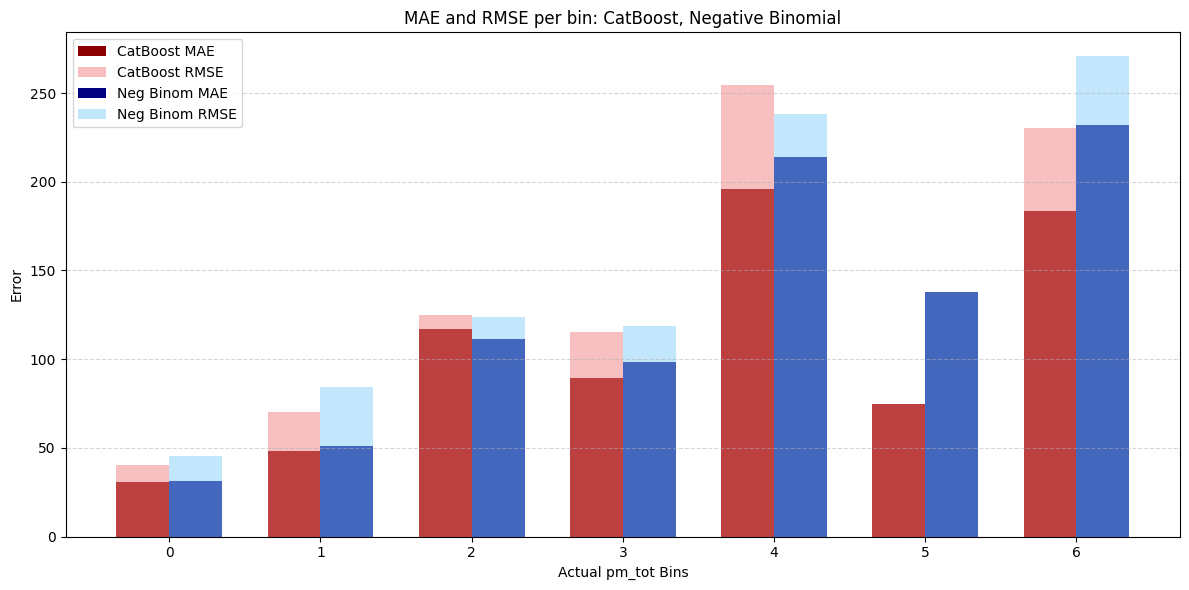

In [68]:
plt.figure(figsize=(10, 6))

#plotting catboost resid
plt.scatter(results_df_cb['Actual'], results_df_cb['Residual'],
            color='red', edgecolor='black', alpha=0.5, label='CatBoost')

#neg binom resid
plt.scatter(results_df_nb['Actual'], results_df_nb['Residual'],
            color='blue', edgecolor='black', alpha=0.5, label='Negative Binomial')

plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Residuals vs Actual pm_tot: CatBoost, Negative Binomial)', pad=10)
plt.xlabel('Actual pm_tot')
plt.ylabel('Residual')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#bin graphing 
def compute_bin_metrics(df, model_name):
    grouped = df.groupby('Bin')
    return pd.DataFrame({
        f'{model_name}_MAE': grouped['Residual'].apply(lambda x: np.mean(np.abs(x))),
        f'{model_name}_RMSE': grouped['Residual'].apply(lambda x: np.sqrt(np.mean(x**2))),
        f'{model_name}_MAPE': grouped.apply(lambda g: 
            np.mean(np.abs((g['Actual'] - g['Predicted']) / (g['Actual']))) * 100),
        f'{model_name}_n': grouped.size()
    }).reindex(bin_labels)

bin_metrics_cb = compute_bin_metrics(results_df_cb, 'CatBoost')
bin_metrics_nb = compute_bin_metrics(results_df_nb, 'NegBinom')
bin_metrics_all = pd.concat([bin_metrics_cb, bin_metrics_nb], axis=1)

x = np.arange(len(bin_labels)) 
width = 0.35

plt.figure(figsize=(12, 6))

#catboost bars
plt.bar(x - width/2, bin_metrics_all['CatBoost_MAE'], 
        width=width, color='darkred', label='CatBoost MAE')

plt.bar(x - width/2, bin_metrics_all['CatBoost_RMSE'], 
        width=width, color='lightcoral', alpha=0.5, label='CatBoost RMSE')

#neg binom bars
plt.bar(x + width/2, bin_metrics_all['NegBinom_MAE'], 
        width=width, color='navy', label='Neg Binom MAE')

plt.bar(x + width/2, bin_metrics_all['NegBinom_RMSE'], 
        width=width, color='lightskyblue', alpha=0.5, label='Neg Binom RMSE')


plt.xlabel('Actual pm_tot Bins')
plt.ylabel('Error')
plt.title('MAE and RMSE per bin: CatBoost, Negative Binomial')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

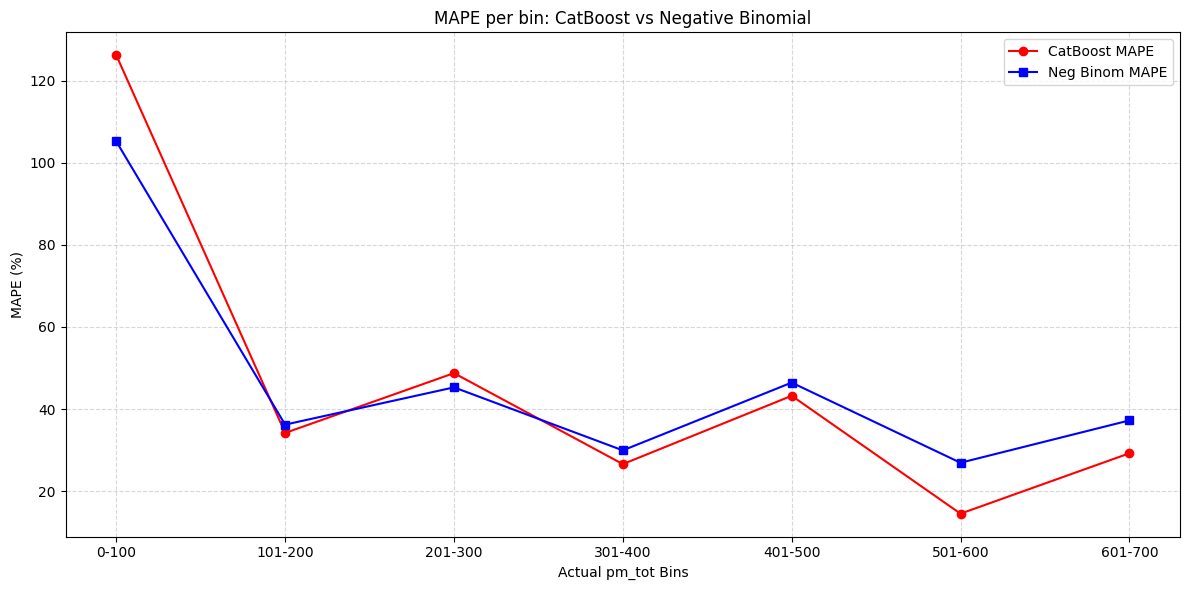

In [69]:
#plotting mape
plt.figure(figsize=(12, 6))

#catboost mape line
plt.plot(bin_labels, bin_metrics_all['CatBoost_MAPE'], 
         marker='o', linestyle='-', color='red', label='CatBoost MAPE')

#neg binom mape line
plt.plot(bin_labels, bin_metrics_all['NegBinom_MAPE'], 
         marker='s', linestyle='-', color='blue', label='Neg Binom MAPE')

plt.title('MAPE per bin: CatBoost vs Negative Binomial')
plt.xlabel('Actual pm_tot Bins')
plt.ylabel('MAPE (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



LOOCV Evaluation Metrics (with Random Search):
Overall RMSE: 92.2808
Mean Absolute Error (MAE): 59.6104
Std Dev of Fold RMSEs: 70.4439


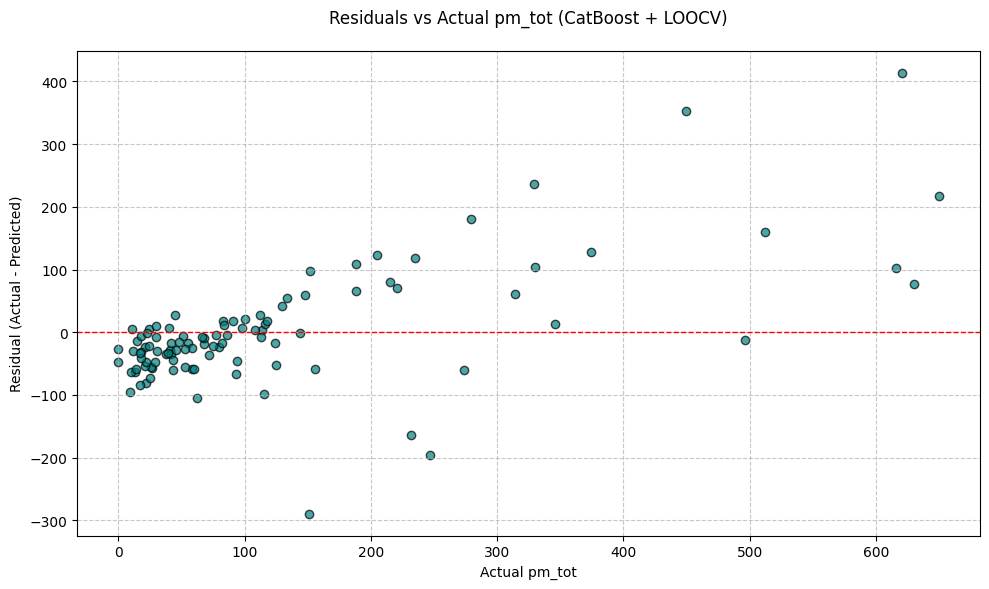

In [ ]:
#same catboost w/ hyperparam tuning, much more computationally expensive 
X = final.drop(columns=['pm_tot'])
y = df['pm_tot']
cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

loo = LeaveOneOut()
rmse_scores = []
mae_scores = []
rmse_bins = []
all_actuals = []
all_preds = []
all_residuals = []

bins = list(range(0, 701, 100))
bin_labels = [f"{i+1}-{i+100}" if i != 0 else "0-100" for i in bins[:-1]]

#hyperparameters
param_dist = {
    'depth': [4, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    
}

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, cat_features=cat_features)

    #tune hyperparameters on inner loop
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=2)
    base_model = CatBoostRegressor(iterations=300, random_seed=2, verbose=0)

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=10,
        cv=inner_cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train, cat_features=cat_features)
    best_model = random_search.best_estimator_

    best_model.fit(train_pool)

    y_pred = best_model.predict(test_pool)[0]
    actual_val = y_test.values[0]
    residual = actual_val - y_pred

    all_actuals.append(actual_val)
    all_preds.append(y_pred)
    all_residuals.append(residual)

    rmse = np.sqrt((actual_val - y_pred) ** 2)
    mae = abs(actual_val - y_pred)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

    bin_index = pd.cut([actual_val], bins=bins, labels=bin_labels, right=True)[0]
    rmse_bins.append(bin_index)

overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
overall_mae = mean_absolute_error(all_actuals, all_preds)
std_fold_rmse = np.std(rmse_scores)

results_df = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Residual': all_residuals,
    'Absolute Error': mae_scores,
    'Bin': rmse_bins
})

print(f"rmse: {overall_rmse:.4f}")
print(f"mae: {overall_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Actual'], results_df['Residual'], 
            color='teal', edgecolor='black', alpha=0.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Actual pm_tot (CatBoost + LOOCV)', pad=10)
plt.xlabel('Actual pm_tot')
plt.ylabel('Residual')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#random forest evaluation

#test catboost using leave one out cross val for more stable measure
X = finalroad.drop(columns=['pm_tot'])
y = finalroad['pm_tot']

loo = LeaveOneOut()

#setting up stores of performance and across bins
rmse_scores = []
rmse_bins = []
all_actuals = []
all_preds = []
all_residuals = []
bins = list(range(0, 701, 100))  # 0-100 to 601-700
bin_labels = [f"{i+1}-{i+100}" if i != 0 else "0-100" for i in bins[:-1]]

#loocv
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=2,
        n_jobs=-1
    )
    
    #evaluate model and store performance
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    actual_val = y_test.values[0]
    pred_val = y_pred[0]
    residual = actual_val - pred_val

    all_actuals.append(actual_val)
    all_preds.append(pred_val)
    all_residuals.append(residual)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    bin_index = pd.cut([actual_val], bins=bins, labels=bin_labels, right=True)[0]
    rmse_bins.append(bin_index)

#evaluate models 
overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
mae = mean_absolute_error(all_actuals, all_preds)

#store the measures later for plotting
results_df_rf = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Residual': all_residuals,
    'RMSE': rmse_scores,
    'Bin': rmse_bins
})


print(f"overall RMSE: {overall_rmse:.4f}")
print(f"MAE: {mae:.4f}")

overall RMSE: 88.9854
MAE: 57.9936


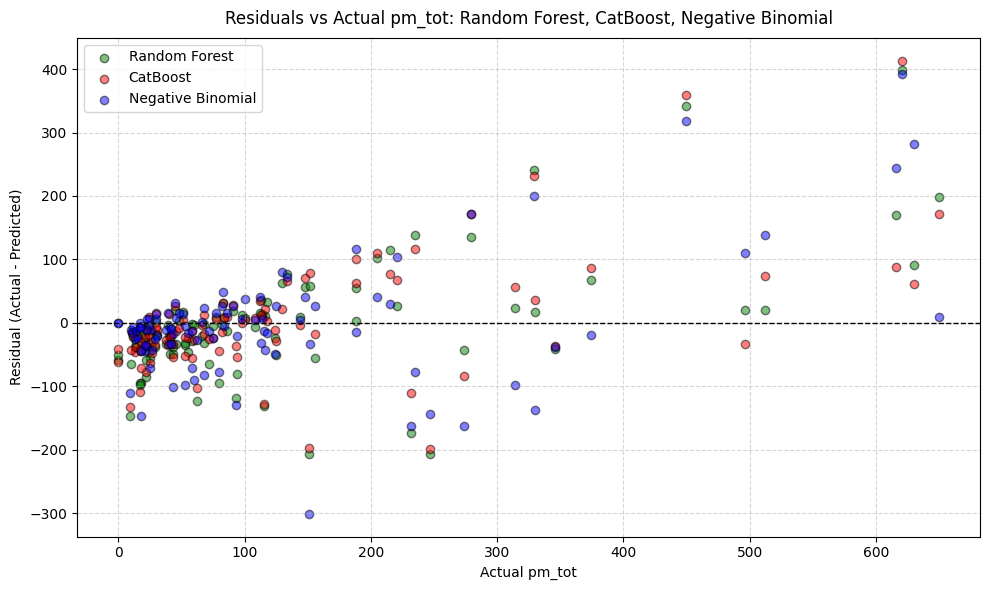

C:\Users\caixd\AppData\Local\Temp\ipykernel_26924\1676930220.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f'{model_name}_MAPE': grouped.apply(lambda g:


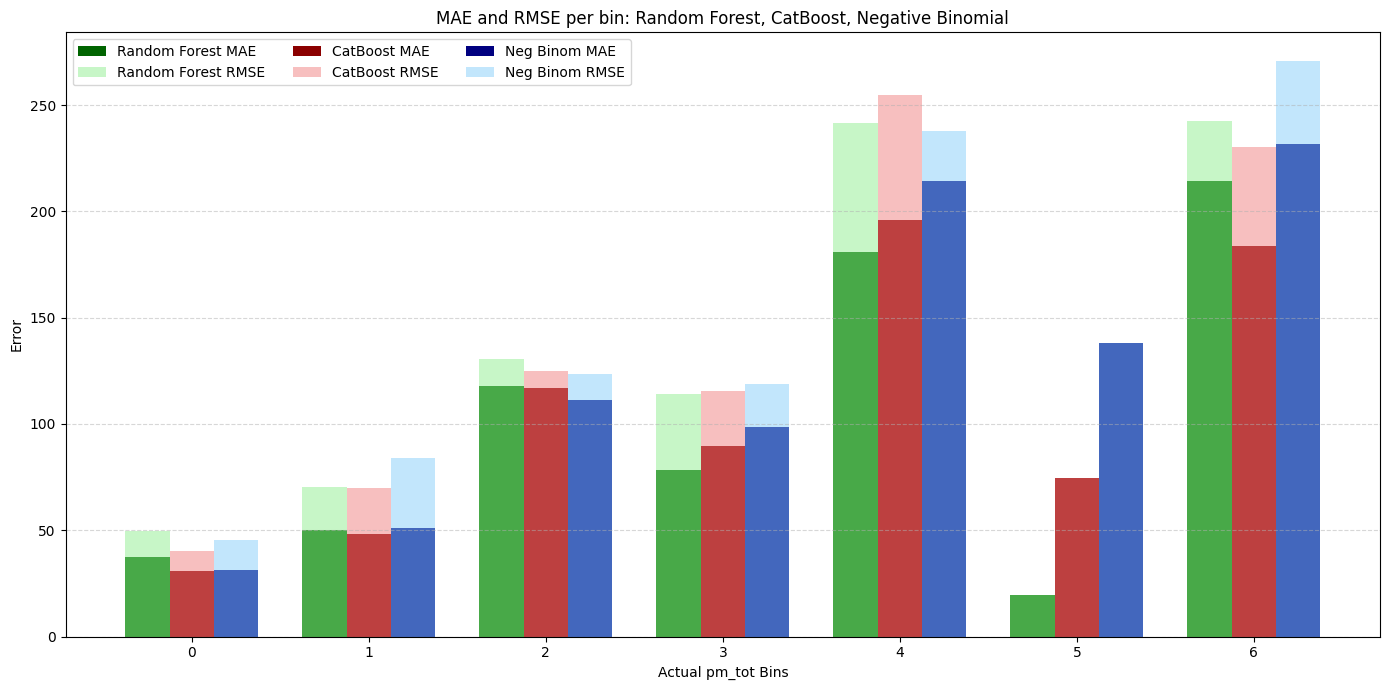

In [ ]:
#plots residuals vs actual overlaid for all 3 methods, + bar chart

plt.figure(figsize=(10, 6))

#resid vs actual for rf
plt.scatter(results_df_rf['Actual'], results_df_rf['Residual'],
            color='green', edgecolor='black', alpha=0.5, label='Random Forest')

#catboost resid
plt.scatter(results_df_cb['Actual'], results_df_cb['Residual'],
            color='red', edgecolor='black', alpha=0.5, label='CatBoost')

#neg binom resid
plt.scatter(results_df_nb['Actual'], results_df_nb['Residual'],
            color='blue', edgecolor='black', alpha=0.5, label='Negative Binomial')

#zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Residuals vs Actual pm_tot: Random Forest, CatBoost, Negative Binomial', pad=10)
plt.xlabel('Actual pm_tot')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#get bin mae rmse and mape
bin_metrics_rf = compute_bin_metrics(results_df_rf, 'RandomForest')

#combine with previous into one df
bin_metrics_all = pd.concat([bin_metrics_rf, bin_metrics_cb, bin_metrics_nb], axis=1)


x = np.arange(len(bin_labels))  
width = 0.25 

plt.figure(figsize=(14, 7))

#rf bars
plt.bar(x - width, bin_metrics_all['RandomForest_MAE'], 
        width=width, color='darkgreen', label='Random Forest MAE')
plt.bar(x - width, bin_metrics_all['RandomForest_RMSE'], 
        width=width, color='lightgreen', alpha=0.5, label='Random Forest RMSE')

#catboost bars
plt.bar(x, bin_metrics_all['CatBoost_MAE'], 
        width=width, color='darkred', label='CatBoost MAE')
plt.bar(x, bin_metrics_all['CatBoost_RMSE'], 
        width=width, color='lightcoral', alpha=0.5, label='CatBoost RMSE')

#neg binom bars
plt.bar(x + width, bin_metrics_all['NegBinom_MAE'], 
        width=width, color='navy', label='Neg Binom MAE')
plt.bar(x + width, bin_metrics_all['NegBinom_RMSE'], 
        width=width, color='lightskyblue', alpha=0.5, label='Neg Binom RMSE')

plt.xlabel('Actual pm_tot Bins')
plt.ylabel('Error')
plt.title('MAE and RMSE per bin: Random Forest, CatBoost, Negative Binomial')
plt.legend(ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


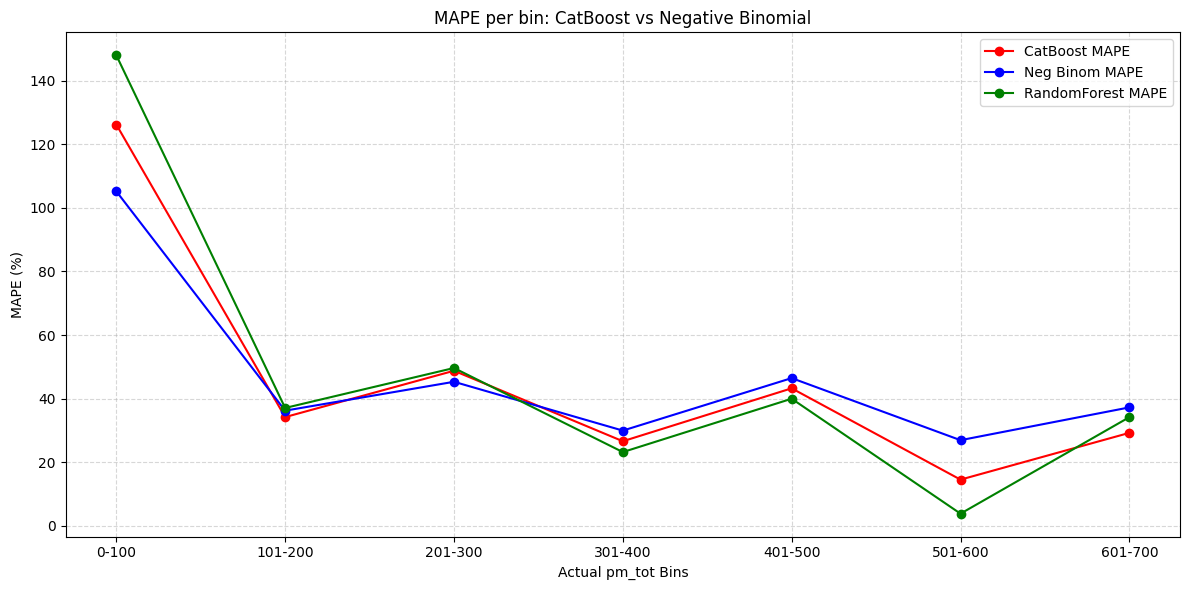

In [65]:
#plotting mape
plt.figure(figsize=(12, 6))

#catboost mape line
plt.plot(bin_labels, bin_metrics_all['CatBoost_MAPE'], 
         marker='o', linestyle='-', color='red', label='CatBoost MAPE')

#neg binom mape line
plt.plot(bin_labels, bin_metrics_all['NegBinom_MAPE'], 
         marker='o', linestyle='-', color='blue', label='Neg Binom MAPE')

#rf mape line
plt.plot(bin_labels, bin_metrics_all['RandomForest_MAPE'], 
         marker='o', linestyle='-', color='green', label='RandomForest MAPE')

plt.title('MAPE per bin: CatBoost vs Negative Binomial')
plt.xlabel('Actual pm_tot Bins')
plt.ylabel('MAPE (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


10 folds:
Mean RMSE: 90.8335 (±22.2582)
MAE: 62.5886 (±15.0139)
R²: 0.5717 (±0.2316)


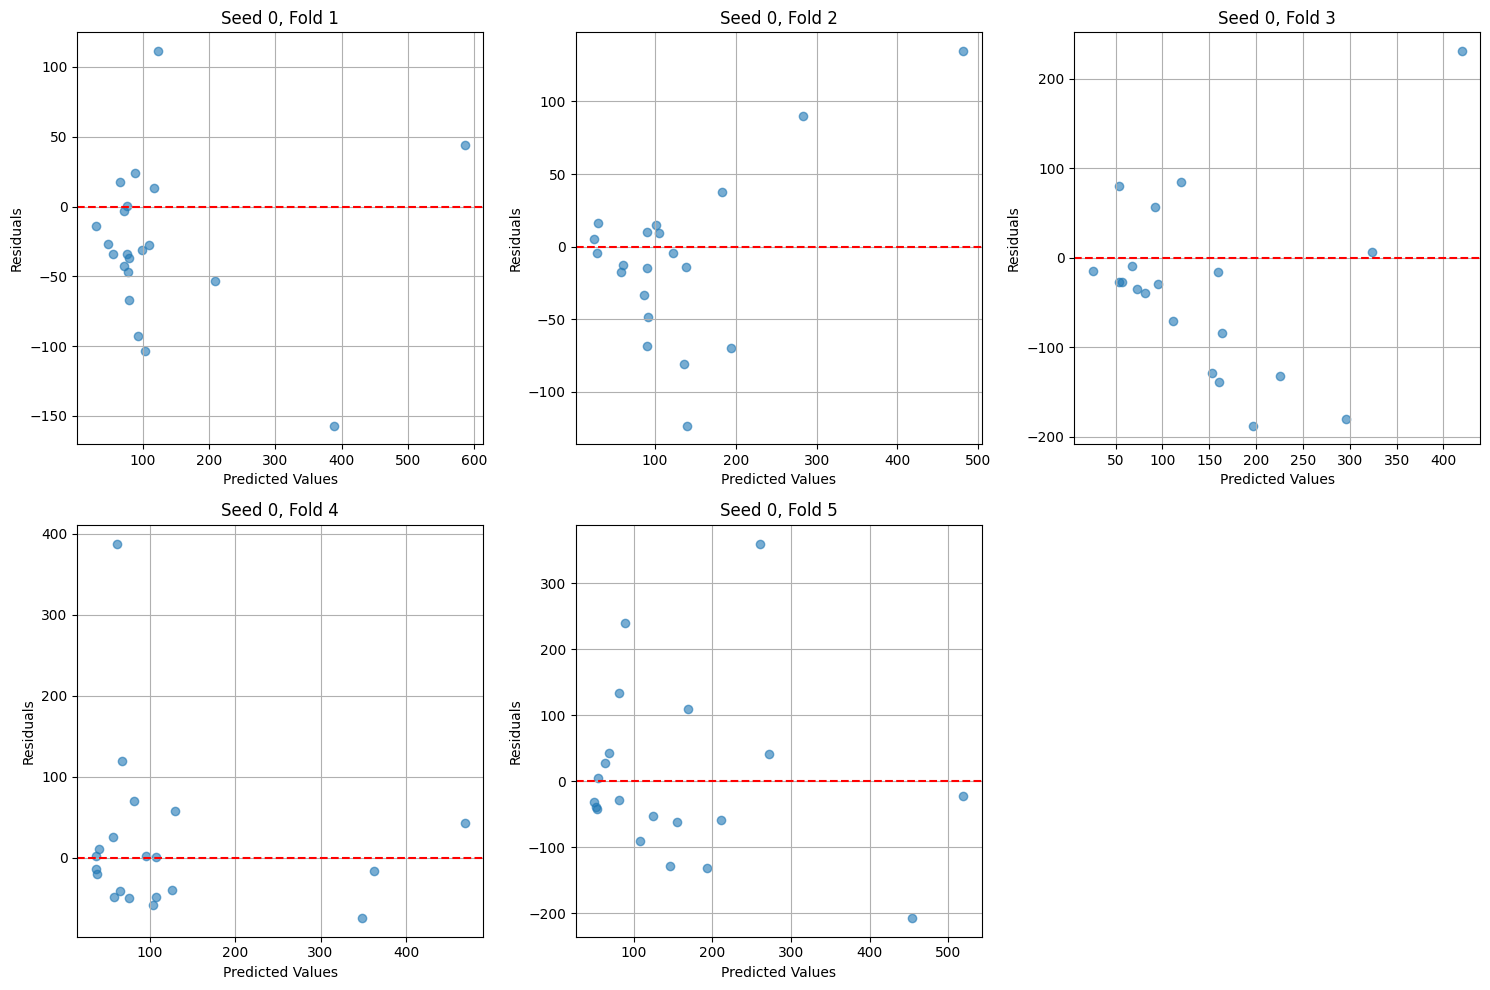

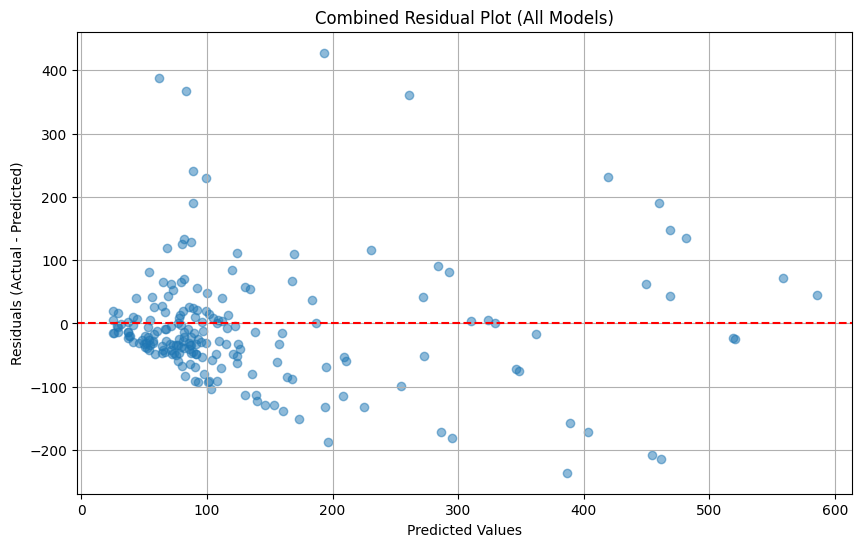


Top 10 Feature Importances:
job_dens_em: 0.0959
job_dens_qm: 0.0935
zch_hm: 0.0898
sig_int_hm: 0.0788
sig_int_qm: 0.0738
job_dens_hm: 0.0705
transit_stops_hm: 0.0430
job_dens: 0.0414
sig_int_em: 0.0353
bus_stops_hm: 0.0345


In [ ]:
X = finalroad.drop(columns=['pm_tot'])
y = df['pm_tot']

rmse_scores = []
mae_scores = []
r2_scores = []
all_y_test = []
all_y_pred = []
residual_plots_data = []  

model_count = 0

for seed in range(2):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = RandomForestRegressor(
            n_estimators=200,
       
            random_state=seed,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
       
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        
        
        if model_count < 5:
            residual_plots_data.append({
                'y_test': y_test,
                'y_pred': y_pred,
                'seed': seed,
                'fold': model_count % 5 + 1
            })
            model_count += 1

mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"{len(rmse_scores)} folds:")
print(f"Mean RMSE: {mean_rmse:.4f} (±{std_rmse:.4f})")
print(f"MAE: {mean_mae:.4f} (±{std_mae:.4f})")
print(f"R²: {mean_r2:.4f} (±{std_r2:.4f})")

plt.figure(figsize=(15, 10))
for i, plot_data in enumerate(residual_plots_data, 1):
    plt.subplot(2, 3, i)
    residuals = plot_data['y_test'] - plot_data['y_pred']
    plt.scatter(plot_data['y_pred'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f"Seed {plot_data['seed']}, Fold {plot_data['fold']}")
    plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
residuals = np.array(all_y_test) - np.array(all_y_pred)
plt.scatter(all_y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Combined Residual Plot (All Models)')
plt.grid(True)
plt.show()

importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nTop 10 Feature Importances:")
for idx in sorted_idx[:10]:
    print(f"{X.columns[idx]}: {importances[idx]:.4f}")
